In [6]:
import torch
from transformers import WavLMModel, Wav2Vec2FeatureExtractor
import torchaudio
import matplotlib.pyplot as plt
import numpy as np

#### Load audio file 

In [7]:
waveform, sr = torchaudio.load("audio/wheretheressmoke.wav")  # shape: [1, num_samples]

# WavLM expects 16kHz sample rate — resample if needed
if sr != 16000:
    resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
    waveform = resampler(waveform)

# Crop the audio file
max_duration_sec = 60
num_samples = int(max_duration_sec * 16000)
waveform = waveform[0, :num_samples] # need mono audio 
waveform = waveform.squeeze(0).numpy()

print("Waveform shape:", waveform.shape)


Waveform shape: (960000,)


#### Load the model and feature extractor

In [8]:
# Load the feature extractor 
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-base-plus")

# Load the pretrained WavLM model
model = WavLMModel.from_pretrained(
    "microsoft/wavlm-base-plus",
    output_hidden_states=True,
    use_safetensors=True,      # for Intel mac (torch 2.2.x)
).eval()


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 2753.98it/s]


In [9]:
# Preprocess waveform
inputs = feature_extractor(waveform, sampling_rate=16000, return_tensors="pt")

# Manually extract cnn outputs 
cnn_layer_outputs = []

def make_hook(i):
    def hook_fn(module, input, output):
        cnn_layer_outputs.append((i, output.detach()))
    return hook_fn

# Register hooks for each CNN conv layer
hook_handles = []
for i, layer in enumerate(model.feature_extractor.conv_layers):
    handle = layer.register_forward_hook(make_hook(i))
    hook_handles.append(handle)


# Forward pass
with torch.no_grad():
    transformer_outputs = model(**inputs)

for handle in hook_handles:
    handle.remove()

for i, tensor in cnn_layer_outputs:
    print(f"CNN Layer {i}: shape = {tensor.shape}")

for i, h in enumerate(transformer_outputs.hidden_states):
    print(f"Transformer Layer {i}: shape = {h.shape}")

/Users/oliviaxujiaming/opt/anaconda3/envs/wavlm_env/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


CNN Layer 0: shape = torch.Size([1, 512, 191999])
CNN Layer 1: shape = torch.Size([1, 512, 95999])
CNN Layer 2: shape = torch.Size([1, 512, 47999])
CNN Layer 3: shape = torch.Size([1, 512, 23999])
CNN Layer 4: shape = torch.Size([1, 512, 11999])
CNN Layer 5: shape = torch.Size([1, 512, 5999])
CNN Layer 6: shape = torch.Size([1, 512, 2999])
Transformer Layer 0: shape = torch.Size([1, 2999, 768])
Transformer Layer 1: shape = torch.Size([1, 2999, 768])
Transformer Layer 2: shape = torch.Size([1, 2999, 768])
Transformer Layer 3: shape = torch.Size([1, 2999, 768])
Transformer Layer 4: shape = torch.Size([1, 2999, 768])
Transformer Layer 5: shape = torch.Size([1, 2999, 768])
Transformer Layer 6: shape = torch.Size([1, 2999, 768])
Transformer Layer 7: shape = torch.Size([1, 2999, 768])
Transformer Layer 8: shape = torch.Size([1, 2999, 768])
Transformer Layer 9: shape = torch.Size([1, 2999, 768])
Transformer Layer 10: shape = torch.Size([1, 2999, 768])
Transformer Layer 11: shape = torch.Size(

In [15]:
# def avg_curvature(X):
#     # X: (dim,nT)
#     # V = X[1:] - X[:-1] #(dim,nT-1)
#     V = np.diff(X, axis=1)
#     # print(V.shape)
#     v1 = V[:, :-1]
#     v2 = V[:, 1:] 
#     dot = np.sum(v1 * v2, axis=1)
#     norm1 = np.linalg.norm(v1, axis=1)
#     norm2 = np.linalg.norm(v2, axis=1)

#     # To avoid division by zero or invalid acos input
#     cos_angles = np.clip(dot / (norm1 * norm2 + 1e-10), -1.0, 1.0)
#     angles = np.degrees(np.arccos(cos_angles))  # in degrees

#     return angles.mean()  

def avg_curvature(X, max_duration_sec):
    V = np.diff(X, axis=0)                      # displacement vectors
    norms = np.linalg.norm(V, axis=1)           # step lengths

    v_prev, v_next = V[:-1], V[1:]
    denom = norms[:-1] * norms[1:] + 1e-12
    cos = (v_prev * v_next).sum(axis=1) / denom
    cos = np.clip(cos, -1.0, 1.0)               
    angles = np.degrees(np.arccos(cos)) 
    deg_per_step = angles.mean()

    total_turn = angles.sum()
    deg_per_sec = total_turn / max_duration_sec


    return deg_per_step, deg_per_sec



In [16]:
cnn_curvature = []
for cnn_layer in range(len(cnn_layer_outputs)):
    X = cnn_layer_outputs[cnn_layer][1].squeeze(0).numpy()  # shape: (nT, dim)
    # print(X.shape)
    _, curvature = avg_curvature(X, max_duration_sec)
    cnn_curvature.append(curvature)
    print(f"Average curvature for CNN Layer {cnn_layer}: {curvature:.2f} degrees")

Average curvature for CNN Layer 0: 1012.84 degrees
Average curvature for CNN Layer 1: 1022.36 degrees
Average curvature for CNN Layer 2: 1017.57 degrees
Average curvature for CNN Layer 3: 1021.76 degrees
Average curvature for CNN Layer 4: 1018.87 degrees
Average curvature for CNN Layer 5: 1007.02 degrees
Average curvature for CNN Layer 6: 1025.10 degrees


In [ ]:
transformer_curvature = []
for transformer_layer in range(len(transformer_outputs.hidden_states)):
    X = transformer_outputs.hidden_states[transformer_layer].squeeze(0).numpy()  # shape: (nT, dim)
    _, curvature = avg_curvature(X.T, )
    transformer_curvature.append(curvature)
    print(f"Average curvature for Transformer Layer {transformer_layer}: {curvature:.2f} degrees")

Average curvature for Transformer Layer 0: 105.91 degrees
Average curvature for Transformer Layer 1: 104.58 degrees
Average curvature for Transformer Layer 2: 104.60 degrees
Average curvature for Transformer Layer 3: 102.59 degrees
Average curvature for Transformer Layer 4: 99.53 degrees
Average curvature for Transformer Layer 5: 96.92 degrees
Average curvature for Transformer Layer 6: 92.54 degrees
Average curvature for Transformer Layer 7: 89.25 degrees
Average curvature for Transformer Layer 8: 87.89 degrees
Average curvature for Transformer Layer 9: 87.05 degrees
Average curvature for Transformer Layer 10: 86.62 degrees
Average curvature for Transformer Layer 11: 87.76 degrees
Average curvature for Transformer Layer 12: 84.16 degrees


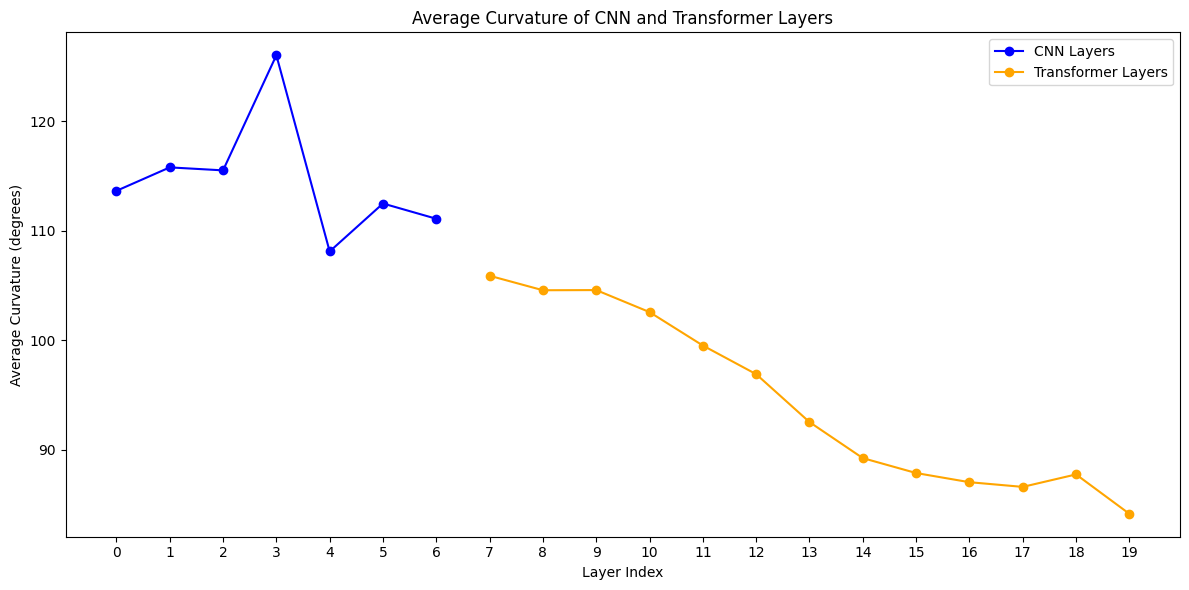

In [13]:
layers = np.arange(len(cnn_curvature) + len(transformer_curvature))
plt.figure(figsize=(12, 6))
plt.plot(layers[:len(cnn_curvature)], cnn_curvature, marker='o', label='CNN Layers', color='blue')
plt.plot(layers[len(cnn_curvature):], transformer_curvature, marker='o', label='Transformer Layers', color='orange')
plt.title('Average Curvature of CNN and Transformer Layers')
plt.xlabel('Layer Index')
plt.ylabel('Average Curvature (degrees)')
plt.xticks(layers)
plt.legend()
plt.tight_layout()
